In [1]:
import numpy as np

import repeated_play

import axelrod as axl

In [2]:
import itertools

from axelrod.action import Action

C, D = Action.C, Action.D

In [3]:
from tqdm.notebook import tqdm

In [4]:
import matplotlib.pyplot as plt

In [5]:
import networkx as nx

In [6]:
from collections import Counter

In [7]:
from scipy import stats

In [8]:
def match_payoffs(player, coplayer, Sx, Sy, memory="one"):
    M = repeated_play.transition_matrix_repeated_game(
        player, coplayer, memory=memory
    )

    ss = repeated_play.stationary_distribution(M)[0]

    return ss, ss @ Sx, ss @ Sy

In [9]:
def reactive_two_t_memory_two(strategy):
    return (strategy[0], strategy[1], strategy[0], strategy[1],
            strategy[2], strategy[3], strategy[2], strategy[3],
            strategy[0], strategy[1], strategy[0], strategy[1],
            strategy[2], strategy[3], strategy[2], strategy[3]
           )

In [10]:
player = [0.99, 0.1, 0.6, 0.3]

prime_player = [0.99, 0.6, 0.1, 0.3]

In [11]:
player_mem2 = reactive_two_t_memory_two(player)

In [12]:
prime_player_mem2 = reactive_two_t_memory_two(prime_player)

In [13]:
b, c = 1, 1/2

Sx = np.array([b - c, -c, b, 0] * 4)

Sy = np.array([b - c, b, -c, 0] * 4)

In [14]:
ss, payoff, _ = match_payoffs(player_mem2, player_mem2, Sx, Sy, memory="two")

In [15]:
ss2, payoff2, _ = match_payoffs(prime_player_mem2, prime_player_mem2, Sx, Sy, memory="two")

# Simulations

In [16]:
class Mem2Transformed(axl.MemoryTwoPlayer):
    
    
    def __init__(self, sixteen_vector) -> None:
        super().__init__(sixteen_vector)
        
    def strategy(self, opponent):
        """Actual strategy definition that determines player's action."""
        turn = len(self.history)
        if turn <= 1:
            return self._random.random_choice(0.5)

        p = self._sixteen_vector[
            ((self.history[-2], opponent.history[-2]), (self.history[-1], opponent.history[-1]))
        ]

        try:
            return self._random.random_choice(p)
        except AttributeError:
            return C if p == 1 else D

In [17]:
donation = axl.game.Game(r=b-c, s=-c, t=b, p=0)

### Player

In [18]:
reps = 20

In [19]:
scores, results_player = [], []

for _ in tqdm(range(reps)):
    
    p1 = Mem2Transformed(player_mem2)
    
    p2 = Mem2Transformed(player_mem2)
    
    match = axl.Match([p1, p2], turns=10**6, game=donation)
    
    _ = match.play()
    
    score = match.final_score_per_turn()[0]
    
    scores.append(score)
    
    results_player.append(match.result)

  0%|          | 0/20 [00:00<?, ?it/s]

In [20]:
results_flatten = [x for xs in results_player for x in xs]

states_player = {history: 0 for history in  itertools.product([C, D], repeat=4)}

for i, hist in enumerate(results_flatten[:-1]):
    states_player[hist + results_flatten[i + 1]] += 1 / (10 ** 6 * reps)

In [21]:
scores2, results_prime_player = [], []

for _ in tqdm(range(reps)):
    
    p1 = Mem2Transformed(prime_player_mem2)
    
    p2 = Mem2Transformed(prime_player_mem2)
    
    match = axl.Match([p1, p2], turns=10**6, game=donation)
    
    _ = match.play()
    
    score = match.final_score_per_turn()[0]
    
    scores2.append(score)
    
    results_prime_player.append(match.result)

  0%|          | 0/20 [00:00<?, ?it/s]

In [22]:
results_flatten2 = [x for xs in results_prime_player for x in xs]

states_prime_player = {history: 0 for history in  itertools.product([C, D], repeat=4)}

for i, hist in enumerate(results_flatten2[:-1]):
    states_prime_player[hist + results_flatten2[i + 1]] += 1 / (10 ** 6 * reps)

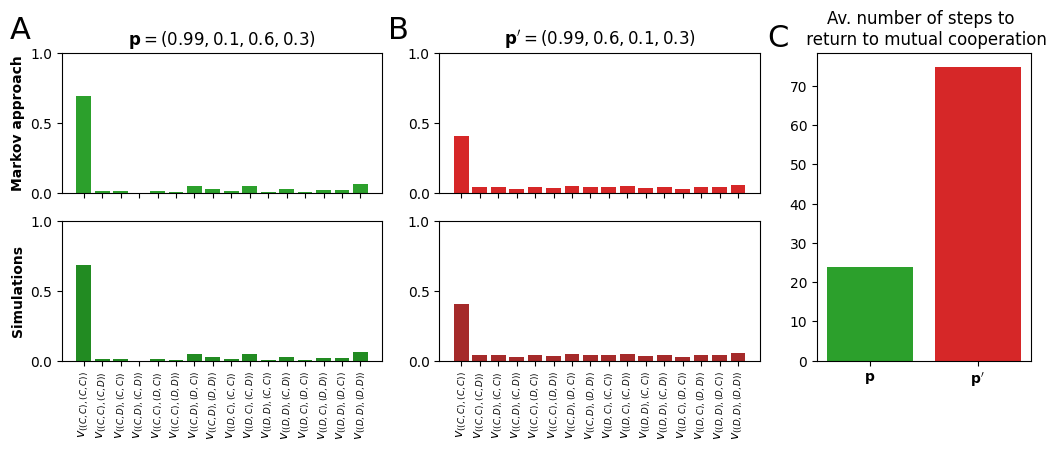

In [44]:
fig, axes = plt.subplot_mosaic("ABE;CDE", figsize=(12.5, 4),
                               gridspec_kw = {'height_ratios':[1, 1], 'width_ratios': [1.5, 1.5, 1]})

# Markov chain process
axes["A"].bar(range(1, 17), ss, color='tab:green');

axes["B"].bar(range(1, 17), ss2, color='tab:red');

# Simulations

axes["C"].bar(range(1, 17), states_player.values(), color='forestgreen');

axes["D"].bar(range(1, 17), states_prime_player.values(), color='brown');



# ticks and stuff

for letter in ['A', "B", "C", "D"]:

    axes[letter].set_ylim(0, 1)

    axes[letter].set_yticks(np.arange(0, 1.1, .5));

    axes[letter].set_xticks(np.arange(1, 17, 1));

for letter in ['C', 'D']:

    axes[letter].set_xticklabels(['$v_{((C, C), (C, C))}$',
                               '$v_{((C, C), (C, D))}$',
                               '$v_{((C, D), (C, C))}$',
                               '$v_{((C, D), (C, D))}$',
                               '$v_{((C, C), (D, C))}$',
                               '$v_{((C, C), (D, D))}$',
                               '$v_{((C, D), (D, C))}$',
                               '$v_{((C, D), (D, D))}$',
                               '$v_{((D, C), (C, C))}$',
                               '$v_{((D, C), (C, D))}$',
                               '$v_{((D, D), (C, C))}$',
                               '$v_{((D, D), (C, D))}$',
                               '$v_{((D, C), (D, C))}$',
                               '$v_{((D, C), (D, D))}$',
                               '$v_{((D, D), (D, C))}$',
                               '$v_{((D, D), (D, D))}$'], rotation=90, fontsize=9
                         );

    axes[letter].xaxis.set_tick_params(labelbottom=True)
    
    
for letter in ['A', 'B']:

    axes[letter].set_xticklabels(['' for _ in range(16)],);

    
axes['A'].set_title("$\mathbf{p}=(0.99, 0.1, 0.6, 0.3)$");

axes['B'].set_title(r"$\mathbf{p'}=(0.99, 0.6, 0.1, 0.3)$");


axes['A'].set_ylabel("Markov approach", fontweight='bold');

axes['C'].set_ylabel("Simulations", fontweight='bold');


axes["E"].bar([0, 1],
             [np.mean([len(cycle) - 1 for cycle in flatten_cycles_player]),
              np.mean([len(cycle) - 1 for cycle in flatten_cycles_prime_player])],
              color=['tab:green', 'tab:red']);

axes["E"].set_xticks([0, 1], ["$\mathbf{p}$", r"$\mathbf{p'}$"]);

axes["E"].set_title("Av. number of steps to \n return to mutual cooperation");


axes["A"].text(-3, 1.1, "A", fontsize="22");
axes["B"].text(-3, 1.1, "B", fontsize="22");
axes["E"].text(-.95, 80, "C", fontsize="22");

fig.savefig("../figures/siFigReactiveTwoPayoffs.pdf", bbox_inches="tight")

# Cycles

Let's transform the histories to letters. More specifically,

- (C, C) -> A
- (C, D) -> B
- (D, C) -> C
- (D, D) -> D

In [24]:
states_to_letters = {(C, C): "A", (C, D): "B", (D, C): "C", (D, D): "D"}

In [25]:
results_player_letters = [[states_to_letters[state] for state in states] 
                          for states in results_player]

Let's write the function for getting cycles

In [26]:
def get_cycles(result):

    overall_cycles = []

    source = ["A", "A"]

    current_cycle = []

    cycle_happening = False

    for i, turn in enumerate(result[:-1]):

        state = [turn, result[i + 1]]

        if state == source and cycle_happening == False:
            cycle_happening = True

            current_cycle = [state]

        elif state == source and len(current_cycle) == 1:
            assert cycle_happening == True
            current_cycle = [state]


        elif state == source and len(current_cycle) > 1:
            assert cycle_happening == True

            current_cycle.append(state)
            overall_cycles.append(current_cycle)

            current_cycle = []
            cycle_happening = False


        elif state != source and cycle_happening == True:
            assert cycle_happening == True
            current_cycle.append(state)
        else:
            pass
    return overall_cycles

Let's test it.

In [27]:
result = ["A", "A", "A"]

get_cycles(result)

[]

In [28]:
result = ["A", "A", "B", "D"]

get_cycles(result)

[]

In [29]:
result = ["A", "A", "B", "D", "A", "A", "C", "D",]

get_cycles(result)

[[['A', 'A'], ['A', 'B'], ['B', 'D'], ['D', 'A'], ['A', 'A']]]

In [30]:
result = ["A", "A", "B", "D", "A", "A", "C", "D", "A", "A", "B", "D",]

get_cycles(result)

[[['A', 'A'], ['A', 'B'], ['B', 'D'], ['D', 'A'], ['A', 'A']]]

In [31]:
result = ["A", "A", "B", "D", "A", "A", "C", "D", "A", "A", "B", "D", "A", "A",]

get_cycles(result)

[[['A', 'A'], ['A', 'B'], ['B', 'D'], ['D', 'A'], ['A', 'A']],
 [['A', 'A'], ['A', 'B'], ['B', 'D'], ['D', 'A'], ['A', 'A']]]

Let's transform both results.

In [32]:
results_prime_player_letters = [[states_to_letters[state] for state in states] 
                          for states in results_prime_player]

Let's get the cycles.

In [33]:
cycles_player = []

for result in results_player_letters:
    cycles = get_cycles(result)
    cycles_player.append(cycles)

In [34]:
# [len(cycle) for cycle in cycles_player]

In [35]:
sum([len(cycle) for cycle in cycles_player])

268396

In [36]:
flatten_cycles_player = [x for xs in cycles_player for x in xs]

In [37]:
np.mean([len(cycle) for cycle in flatten_cycles_player])

24.904346562541917

Let's get the cycles for prime player.

In [38]:
cycles_prime_player = []

for result in results_prime_player_letters:
    cycles = get_cycles(result)
    cycles_prime_player.append(cycles)

In [39]:
sum([len(cycle) for cycle in cycles_prime_player])

158095

In [40]:
flatten_cycles_prime_player = [x for xs in cycles_prime_player for x in xs]

In [41]:
np.mean([len(cycle) for cycle in flatten_cycles_prime_player])

75.68900977260508

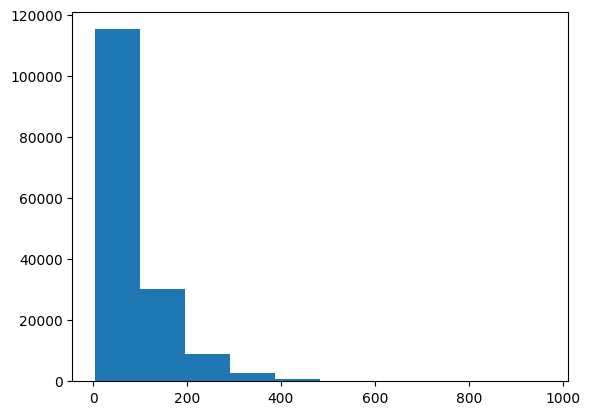

In [42]:
plt.hist([len(cycle) for cycle in flatten_cycles_prime_player]);

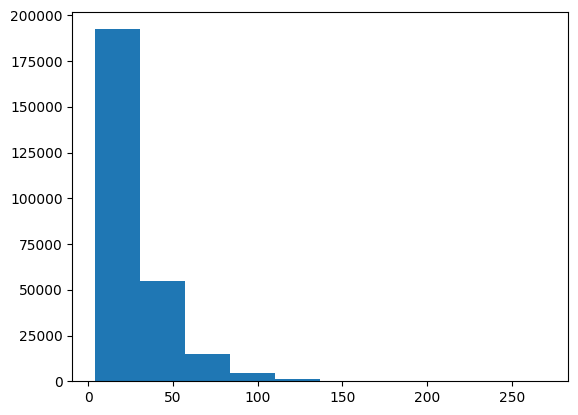

In [43]:
plt.hist([len(cycle) for cycle in flatten_cycles_player]);

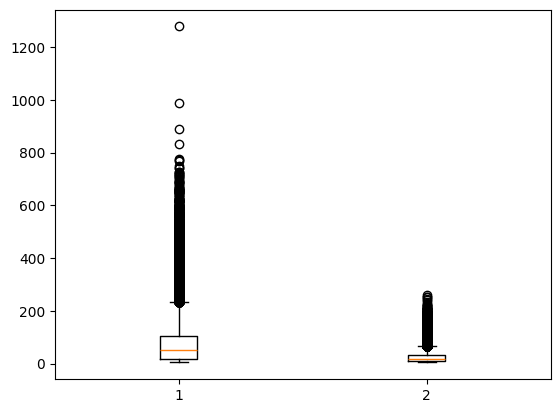

In [70]:
plt.boxplot([[len(cycle) for cycle in flatten_cycles_prime_player],
            [len(cycle) for cycle in flatten_cycles_player]]);


In [107]:
c = Counter([len(cycle) for cycle in flatten_cycles_prime_player])

In [108]:
c.most_common(5)

[(4, 9269), (6, 5948), (8, 4259), (10, 3409), (12, 2752)]

In [109]:
c = Counter([len(cycle) for cycle in flatten_cycles_player])

In [110]:
c.most_common(5)

[(4, 15527), (8, 10520), (9, 10034), (7, 9778), (10, 9575)]

Let's write it as sequence so we can find duplicates and the most common cycles.

In [75]:
sequences_player = []

for cycle in flatten_cycles_player:

    sequence = "-".join(["".join(state) for state in cycle])
    
    sequences_player.append(sequence)

In [76]:
len(sequences_player)

268396

In [77]:
count = Counter(sequences_player)

In [78]:
count.most_common(15)

[('AA-AB-BA-AA', 7935),
 ('AA-AC-CA-AA', 7714),
 ('AA-AC-CB-BA-AA', 4289),
 ('AA-AB-BC-CA-AA', 4204),
 ('AA-AC-CB-BC-CA-AA', 2280),
 ('AA-AB-BC-CB-BA-AA', 2275),
 ('AA-AC-CB-BC-CB-BA-AA', 1265),
 ('AA-AB-BC-CD-DC-CA-AA', 1265),
 ('AA-AC-CB-BD-DB-BA-AA', 1222),
 ('AA-AB-BC-CB-BC-CA-AA', 1196),
 ('AA-AB-BC-CD-DD-DA-AA', 870),
 ('AA-AC-CB-BD-DD-DA-AA', 867),
 ('AA-AC-CB-BB-BA-AA', 837),
 ('AA-AB-BC-CC-CA-AA', 835),
 ('AA-AC-CB-BC-CB-BC-CA-AA', 721)]

In [65]:
(7935 / len(sequences_player)) * 100

2.956452406146142

In [80]:
(4204  / len(sequences_player)) * 100

1.5663422703766077

In [81]:
(2275 / len(sequences_player)) * 100

0.8476281315667893

In [92]:
sequences_prime_player = []

for cycle in flatten_cycles_prime_player:

    sequence = "-".join(["".join(state) for state in cycle])
    
    sequences_prime_player.append(sequence)

In [93]:
len(sequences_prime_player)

158095

In [94]:
count_prime = Counter(sequences_prime_player)

In [95]:
count_prime.most_common(15)

[('AA-AC-CA-AA', 4643),
 ('AA-AB-BA-AA', 4553),
 ('AA-AC-CA-AB-BA-AA', 2450),
 ('AA-AB-BA-AC-CA-AA', 2425),
 ('AA-AC-CA-AB-BA-AC-CA-AA', 1296),
 ('AA-AB-BA-AC-CA-AB-BA-AA', 1272),
 ('AA-AC-CA-AB-BA-AC-CA-AB-BA-AA', 687),
 ('AA-AB-BA-AC-CA-AB-BA-AC-CA-AA', 676),
 ('AA-AC-CB-BB-BA-AA', 535),
 ('AA-AB-BC-CC-CA-AA', 523),
 ('AA-AB-BA-AC-CA-AB-BA-AC-CA-AB-BA-AA', 373),
 ('AA-AC-CA-AB-BA-AC-CA-AB-BA-AC-CA-AA', 369),
 ('AA-AB-BC-CC-CA-AB-BA-AA', 273),
 ('AA-AC-CA-AB-BC-CC-CA-AA', 254),
 ('AA-AC-CB-BB-BA-AC-CA-AA', 253)]

In [96]:
(4553 / len(sequences_prime_player)) * 100

2.87991397577406

In [97]:
(2425 / len(sequences_prime_player)) * 100

1.5338878522407413

In [98]:
(1272 / len(sequences_prime_player)) * 100

0.8045795249691641